In [1]:
import os
import openslide
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display
import skimage.io

In [2]:
data_dir = r'D:\PhDMain\Courses\DeepLearning\PANDAS\train_images'
mask_dir = r'D:\PhDMain\Courses\DeepLearning\PANDAS\train_label_masks'
labels = pd.read_csv(r'D:\PhDMain\Courses\DeepLearning\PANDAS\train.csv')
labels.shape

In [5]:
labels['data_provider'].describe()

count          10616
unique             2
top       karolinska
freq            5456
Name: data_provider, dtype: object

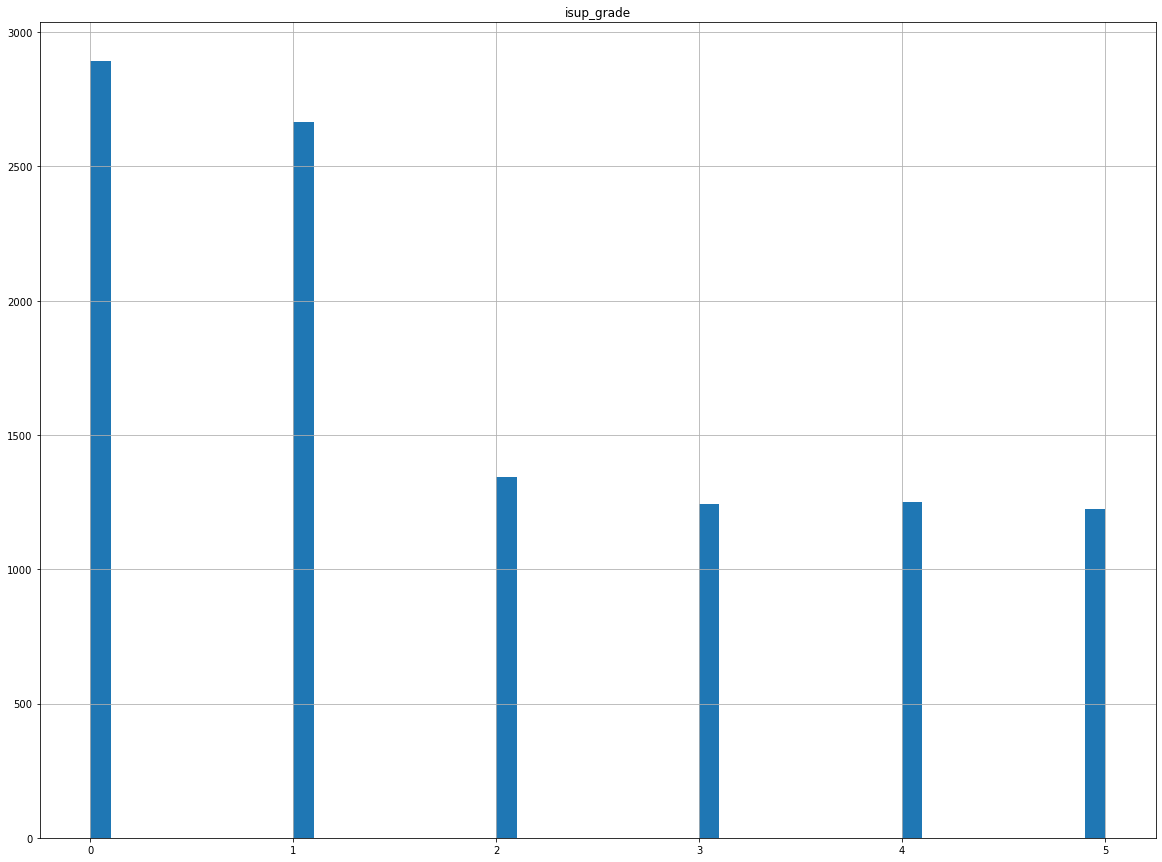

In [6]:
labels.hist(bins=50, figsize=(20,15))
plt.show()
#labels.drop(columns='image_id',index='00a7fb880dc12c5de82df39b30533da9')

In [8]:
#Vi rensar bort tveksamma bilder. För detta använder vi den databasen av sådana bilder från 
#https://www.kaggle.com/dannellyz/collection-of-600-suspicious-slides-data-loader
import shutil
SuspFolder=r'D:\PhDMain\Courses\DeepLearning\PANDAS\SuspiciousSlides'
susp_slides = pd.read_csv(r'D:\PhDMain\Courses\DeepLearning\PANDAS\SuspiciousSlides\PANDA_suspicious_slides.csv')
image_ids=susp_slides.image_id.values
for i in range(len(image_ids)):
    inputfile=os.path.join(data_dir,image_ids[i]+'.tiff')
    if not os.path.isfile(inputfile):
        continue
    labels=labels[labels.image_id.values != image_ids[i]]
    outputfile=os.path.join(SuspFolder,image_ids[i]+'.tiff')
    shutil.move(inputfile,outputfile)
print(len(labels))    

9954


In [9]:
#Vi delar här in data i tränings-,validerings- och testset. Vi ser till att absolutmängden bilder 
#i test och valideringsset är samma. För detta använder vi sklearn.
prop_test_valid=0.1
no_test_valid=prop_test_valid*len(labels)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=prop_test_valid, random_state=42)
for non_test_index, test_index in split.split(labels, labels["isup_grade"]):
    strat_non_test_label = labels.iloc[non_test_index]
    strat_test_label = labels.iloc[test_index]
prop_valid=no_test_valid/len(strat_non_test_label)
split = StratifiedShuffleSplit(n_splits=1, test_size=prop_valid, random_state=43)
for train_index, valid_index in split.split(strat_non_test_label, strat_non_test_label["isup_grade"]):
    strat_train_label = strat_non_test_label.iloc[train_index]
    strat_valid_label = strat_non_test_label.iloc[valid_index]

print(len(strat_train_label),len(strat_valid_label),len(strat_test_label))

7962 996 996


In [10]:
#Vi definerar en funktion för att dela upp varje bild i ett antal N subbilder, på så sätt att subbilderna är de
#med lägst summa på deras pixelvärden, så att vi i stor utsträckning minskar de vita, fysiologiska irrelevanta pixlarna.
#Kod har vi lånat från https://www.kaggle.com/iafoss/panda-16x128x128-tiles
def tile_image(path,N,sz,level):

    #Först hittar vi hur mycket vi behöver padda bilden så att bilden blir en multipel av antalet pixlar (=sz) 
    #vi vill ha i varje sub-bild (som är N till antalet.
    img = skimage.io.MultiImage(path)[level]
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz


    #Vi paddar till höger och vänster och sätter värdet till 255 i alla kanaler, dvs. vitt
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255) 

    #Vi flyttar runt pixlarna lite så att vi får en bild med dimensionerna N x sz x sz x 3
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4)
    img = img.reshape(-1,sz,sz,3)



    
    if len(img) < N: #om vi inte kan fylla upp N sub-bilder paddar vi lite till så att vi kan det
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255) 

    #transform tile into a row of pixel values. Sum value of each row; this will give a one dimensional vector. 
    #Call argsort to sort these. Get the first N ones; sorting in ascending order, these will give the ones with
    #the lowest pixel values.
    #Vi transformerar varje enskild subbild till en lista med pixlar som vi sedan sumerar; vi sorterar därefter listan
    #i stigande ordning och tar de N första.
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(1))[:N] 
    img = img[idxs]
    
    #Vi gör därefter om bilderna till en bild av storleken sqrt(N)*sz x sqrt(N)*sz x 3 
    #och returnerar den.
    result=np.ndarray(shape=(np.sqrt(N).astype(int)*sz,np.sqrt(N).astype(int)*sz,3),dtype=int)
    counter=0
    rows=np.sqrt(N).astype(int)
    columns=rows
    for row in range(rows):
        for column in range(columns):
            q=img[counter,:,:,:]
            result[row*sz:(row+1)*sz,column*sz:(column+1)*sz,:]=q
            counter=counter+1
    #reshape to final batch; -1 tells numpy to figure out the size of that dimension
    return result
    

In [29]:
#Här går vi genom varje set, skapar bilder enligt metoden ovan, applicerar preprocessing-funktionen från ResNet50V2
#och sparar dem som komprimerade numpy-arrays.
train_labels_set=set(strat_train_label.image_id.values)
valid_labels_set=set(strat_valid_label.image_id.values)
test_labels_set=set(strat_test_label.image_id.values)

N_large=100
N_small=16
sz=128

from tensorflow.keras.applications.resnet_v2 import preprocess_input
names = [name for name in os.listdir(data_dir)]
for name in names:
    file_label=name[:-5]
    path=os.path.join(data_dir,name)
    if file_label in train_labels_set:
        output_folder='D:\PhDMain\Courses\DeepLearning\PANDAS\ProcessedImages\TrainSet\\'
    elif file_label in valid_labels_set:
        output_folder='D:\PhDMain\Courses\DeepLearning\PANDAS\ProcessedImages\ValidationSet\\'
    elif file_label in test_labels_set:
        output_folder='D:\PhDMain\Courses\DeepLearning\PANDAS\ProcessedImages\TestSet\\'
    else:
        print('Error; label does not belong to any set',file_label)
        break
    tiled_img_large=preprocess_input(tile_image(path,N_large,sz,1))
    tiled_img_small=preprocess_input(tile_image(path,N_small,sz,2))
    np.savez_compressed(output_folder+file_label+'.npz', large=tiled_img_large, small=tiled_img_small)

0005f7aaab2800f6170c399693a96917.tiff
